In this assignment, we are going to implement see if we can optimally select a subset of training instances for supervised learning.

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

We are going to work with the MNIST dataset, a popular dataset for hand-written digit recognition. Here we load the datatset.

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1) # -1 means the last axis
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("Loaded {} train samples".format(x_train.shape[0]))
print("Loaded {} test samples".format(x_test.shape[0]))

#! scale down the training set to 10_000 samples
import random
random.seed(42)
train_size = 10_200
test_size = 200
# make x_train have roughly same number of samples for each class:
# x_train = np.concatenate([x_train[y_train == i][:train_size // 10] for i in range(10)])
# y_train = np.concatenate([y_train[y_train == i][:train_size // 10] for i in range(10)])
# # make x_test have roughly same number of samples for each class:
# x_test = np.concatenate([x_test[y_test == i][:test_size // 10] for i in range(10)])
# y_test = np.concatenate([y_test[y_test == i][:test_size // 10] for i in range(10)])

# x_train = x_train[:train_size]
# y_train = y_train[:train_size]
# get test sets from x_train and y_train:
# random_indices = np.random.choice(x_train.shape[0], size=test_size, replace=False)
# x_test = x_train[random_indices]
# y_test = y_train[random_indices]
# delete the test sets from x_train and y_train:
# x_train = np.delete(x_train, random_indices, axis=0)
# y_train = np.delete(y_train, random_indices)

print("x_train shape:", x_train.shape)
print("Loaded {} train samples".format(x_train.shape[0]))
print("Loaded {} test samples".format(x_test.shape[0]))
print(f"Num of data points per class in train set: {np.unique(y_train, return_counts=True)[1]}")


x_train shape: (60000, 28, 28, 1)
Loaded 60000 train samples
Loaded 10000 test samples
x_train shape: (60000, 28, 28, 1)
Loaded 60000 train samples
Loaded 10000 test samples
Num of data points per class in train set: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


In [3]:
# count how many data points are in each class
res = np.unique(y_train, return_counts=True)
print({k:v for k,v in zip(res[0], res[1])})

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


Now corrupt the labels with common types of mistakes. The variable 'noise_probability' controls the amount of errors introduced.

In [4]:
import random
noise_probability = 0.5
SEED = 314159

random.seed(SEED)

def index(array, item):
    for i in range(len(array)):
        if item == array[i]:
            return i
    return -1

def corrupt_label(y, y_index, err):
    n = len(err)
    # select an element at random (index != found)
    if (y_index == n-1):
        noisy_label = err[0]
    else:
        noisy_label = err[(y_index + 1)%n]
    return noisy_label

# We corrupt the MNIST data with some common mistakes, such as 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.
def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        p = random.random()

        if p < noise_probability:
            y = y_train[i]

            y_index = index(err_es_1, y)
            if y_index >= 0:
                y_noisy = corrupt_label(y, y_index, err_es_1)
            else:
                y_index = index(err_es_2, y)
                y_noisy = corrupt_label(y, y_index, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

corruptions, corrupted_indexes = corrupt_labels(y_train, noise_probability)
print ("Corruptions: " + str(corruptions))
print ("Number of corruptions: {}".format(len(list(corrupted_indexes.keys()))))


Corruptions: {'5->6': 2666, '0->2': 2917, '4->7': 2888, '1->4': 3385, '9->0': 2997, '2->3': 2969, '3->5': 3027, '7->1': 3204, '8->9': 2911, '6->8': 2960}
Number of corruptions: 29934


In [5]:
print(f"Length of pruned indexes: {len(corrupted_indexes)}")


Length of pruned indexes: 29934


In [6]:
# count how many data points are in each class after corruption
res = np.unique(y_train, return_counts=True)
print({k:v for k,v in zip(res[0], res[1])})

{0: 6003, 1: 6561, 2: 5906, 3: 6073, 4: 6339, 5: 5782, 6: 5624, 7: 5949, 8: 5900, 9: 5863}


In [7]:
# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

Supervised (parametric) training with the (noisy) labeled examples. Note that this model is trained on the entire dataset (the value of the parameter pruned_indexes is null here, which means that we leave out no points), which is noisy (20% of the labels are corrupted). Now the question is: is this the best model that we can train or can we do better?

In [8]:
batch_size = 128
epochs = 3
validation_split=0.1


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

def prune_points(x_train, y_train, pruned_indexes):
    num_samples = x_train.shape[0]
    x_train_pruned = []
    y_train_pruned = []
    for i in range(num_samples):
        if not i in pruned_indexes:
            x_train_pruned.append(x_train[i])
            y_train_pruned.append(y_train[i])

    return np.array(x_train_pruned), np.array(y_train_pruned)

def trainAndEvaluateModel(x_train, y_train, x_test, y_test, model, pruned_indexes):

    if not pruned_indexes == None:
        x_train_pruned, y_train_pruned = prune_points(x_train, y_train, pruned_indexes)
    else:
        x_train_pruned = x_train
        y_train_pruned = y_train

    model.fit(x_train_pruned, y_train_pruned, batch_size=batch_size, epochs=epochs)
    loss, accuracy = model.evaluate(x_test, y_test)
    keras.backend.clear_session() # remove previous training weights
    
    return loss, accuracy
    


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dropout (Dropout)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

And we call the following function to train a model on the entire dataset and evaluate it on the test set. The accuracy on the test set is quite good, but can we do better?

In [9]:
# trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, None)

You need to implement a subset selection function that when called will return a subset of instances which will be used to train the model. This setup ensures that you also pass in another dictionary which contains the indexes of the instances that you would not want to use while training the model, i.e., it should contain a list of indexes that you would decide to **leave out** for training.

Here's the code and a sample implementation that returns a randomly chosen set of instances that you are to be left out. Since we chose 70% probability of label corruption (check the **noise_probability** parameter), we also select a subset where we leave out the same proportion of points. This is a baseline implementation and obviously you should aim to achieve better results than this.

In [10]:
# Here 'x_train', 'y_train' and model' are an unused parameters. But you may get better results by leveraging these.
def baseLinePrunedSubsetMethod(x_train, y_train, model):
    pruned_indexes = {}
    num_samples = x_train.shape[0]
    for i in range(num_samples):
        p = random.random()

        if p < noise_probability: # this is the global variable (only useful for this naive approach)
            pruned_indexes[i] = i
    return pruned_indexes

Let's see how this naive baseline works.

In [11]:
pruned_indexes = baseLinePrunedSubsetMethod(x_train, y_train, model)
# trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)

Let's now see if we had known what points were actually corrupted (more of a hypothetical unrealistic situation), does leaving out those points actually improve the model's effectiveness. It turns out that it does!

In [12]:
# trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, corrupted_indexes)

Your task is to implement your own version of (say of name **myPrunedSubsetMethod** (which should take as arguments x_train, y_train, and the model). The function should return a dictionary of indexes that are to be left out. Plug your function in and evaluate the results. Write a thorough report on the methodology and analyse the results.

Some hints:
You can approach this as a discrete state space optimisation problem, where firstly you can define a "selection batch size" (this is not the same as training batch size), which decides which batch of instances you're going to leave out. For instance, if you are in a state where the training set is $X$, you may select (by some heuristics) which points you're gonna leave out (let that set be $\delta \subset X$) so that a child state becomes $X' = X - \delta$. Similarly, if you choose a different $\delta$ you get a different child state. You then need to train and evaluate (call the function *trainAndEvaluateModel*) to see if that child state led to an improvement or not.

You are free to use any algorithm, e.g., simulated annealing, A* search, genetic algorithm etc. to implement this discrete state space optimisation.

# Using Genetic Algorithm:

In [13]:
from math import ceil

INPUT_SIZE = x_train.shape[0]

#' Define GA parameters
POPULATION_SIZE = 1 # number of individuals in population
SELECTION_SIZE = ceil(0.5*POPULATION_SIZE) # number of individuals to select for next generation
BATTLE_PARTICIPANTS = 4 # number of individuals to participate in a tournament
MUTATION_RATE = 0.01 # probability of mutating each individual
CROSSOVER_RATE = 0.3 # probability of crossing over two individuals
CROSSOVER_POINTS = 2 # number of crossover points
GENERATIONS = 1 # number of generations
ELITE_NUM = 2 # number of elite individuals to keep from one generation to the next

## Initialise Population:

Prioritization scores: {0: 1.09, 1: 1.0, 2: 1.11, 3: 1.08, 4: 1.04, 5: 1.13, 6: 1.17, 7: 1.1, 8: 1.11, 9: 1.12}
Length of pruned indexes: 59994
Epoch 1/3
1/1 [==============================] - 0s 377ms/step - loss: 2.2842 - accuracy: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 0s 5ms/step - loss: 2.0942 - accuracy: 0.5000
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 2.3399 - accuracy: 0.1125
indv: 0, bias: 0.5, accuracy: 0.11249999701976776
Length of pruned indexes: 59994
Epoch 1/3
1/1 [==============================] - 0s 73ms/step - loss: 2.1667 - accuracy: 0.3333
Epoch 2/3
1/1 [==============================] - 0s 5ms/step - loss: 2.0881 - accuracy: 0.1667
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 2.3983 - accuracy: 0.1016
indv: 1, bias: 0.5, accuracy: 0.10159999877214432
Length of pruned indexes: 59992
Epoch 1/3
1/1 [==============================] - 0s 73ms/step - loss: 2.5000 - accuracy: 0.0000e+00
Epoch 2

Text(0.5, 1.0, 'Max accuracy vs bias strength')

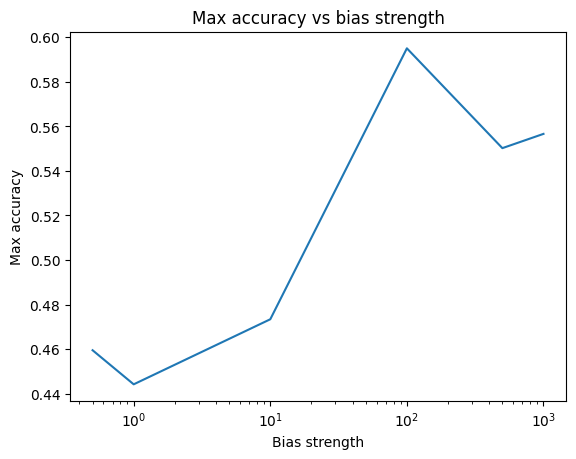

In [14]:
def create_population(population_size, input_size, y_train, bias_strength=100):
    # 0 means prune the point, 1 means keep the point:
    population = []
    
    POPULATION_SIZE = population_size
    INPUT_SIZE = input_size

    # Calculate inverse frequencies for prioritization
    classes, freq = np.unique(y_train, return_counts=True)
    class_frequencies = {k:v for k,v in zip(classes, freq)}
    max_freq = max(class_frequencies.values())
    prioritization_scores = {digit_class: round(max_freq / freq, 2) for digit_class, freq in class_frequencies.items()}
    print(f"Prioritization scores: {prioritization_scores}")
    for _ in range(POPULATION_SIZE):
        individual = np.ones(INPUT_SIZE, dtype=int)
        for i in range(INPUT_SIZE):
            class_label = y_train[i]
            # Bias towards selecting indices of more frequent classes
            if random.random() < ((prioritization_scores[class_label] / max_freq) * bias_strength):
                individual[i] = 0
        
        # check if individual is not in population already:
        # bc of this, accuracy is low for the first few individuals then it gets better.
        if not np.any([np.array_equal(individual, indv) for indv in population]):
            population.append(individual)
            
    # convert to tuple for hashability:
    population = [tuple(individual) for individual in population]

    return population

#! Example usage:
population_size = 100
bias = 100
res = []
max_acc = []
bias_list = [0.5, 1, 10, 100, 500, 1000]
for bias in bias_list:
    random.seed(SEED)
    population = create_population(population_size, INPUT_SIZE, y_train, bias_strength=bias)
    for i, indv in enumerate(population):
        pruned_indexes = {i:i for i,elt in enumerate(indv) if elt == 1}
        print(f"Length of pruned indexes: {len(pruned_indexes)}")
        loss, accuracy = trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)
        print(f"indv: {i}, bias: {bias}, accuracy: {accuracy}")
        res.append(accuracy)
        
    max_acc.append(max(res))
    res = []
    
import matplotlib.pyplot as plt
plt.plot(bias_list, max_acc)
plt.xscale('log')
plt.xlabel('Bias strength')
plt.ylabel('Max accuracy')
plt.title('Max accuracy vs bias strength')


In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(res, 'o-')
# # plt.xscale('log')
# plt.xlabel(f'Individuals')
# plt.ylabel('accuracy')
# plt.title(f'With bias = {bias}')

# # save svg:
# import os
# base = f"img/population"
# counter = 0
# filename = f'bias_{bias}_max_accuracy_{round(max(res), 2)}'
# while os.path.exists(f"{base}/{filename}_{counter}.svg"):
#     counter += 1
    
# path = os.path.join(base, filename + f"_{counter}.svg")
# print(f"Saving to {path}")
# plt.savefig(path, format='svg')

## Run Genetic Algorithm:
- Evaluate fitness of each individual
- Select parents
- Crossover
- Mutation

In [ ]:
from functools import lru_cache
import time
import os

@lru_cache(maxsize=None)
def evaluate_fitness(individual):
    pruned_indexes = {i:i for i,elt in enumerate(individual) if elt == 1}
    loss, accuracy = trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)
    return accuracy

def find_top_N_elements(population, fitness_scores, N):
    top_N = []
    for _ in range(N):
        max_index = np.argmax(fitness_scores)
        top_N.append(population[max_index])
        fitness_scores[max_index] = -1
    return top_N

def select_individuals(population, fitness_scores, selection_size, battle_participants, elite_num):
    # Select individuals for next generation
    selected_individuals = []
    
    #' ELITISM:
    selected_individuals.extend(find_top_N_elements(population, fitness_scores, elite_num))
    
    #' TOURNAMENT SELECTION:
    while len(selected_individuals) < selection_size:
        # Select BATTLE_PARTICIPANTS individuals at random
        participants = random.sample(list(zip(population, fitness_scores)), battle_participants)
        # Sort participants by fitness score
        sorted_participants = sorted(participants, key=lambda x: x[1], reverse=True)
        # Select the best individual from the tournament
        selected_individuals.append(sorted_participants[0][0])
    return selected_individuals

def crossover(individual_1, individual_2, crossover_rate, crossover_points):
    # Crossover individuals
    if random.random() < crossover_rate:
        crossover_points = random.sample(range(1, len(individual_1)), crossover_points)
        crossover_points.sort()
        new_individual_1 = individual_1[:crossover_points[0]] + individual_2[crossover_points[0]:crossover_points[1]] + individual_1[crossover_points[1]:]
        new_individual_2 = individual_2[:crossover_points[0]] + individual_1[crossover_points[0]:crossover_points[1]] + individual_2[crossover_points[1]:]
        return new_individual_1, new_individual_2
    else:
        return individual_1, individual_2
    
def mutate(individual, mutation_rate):
    # Mutate individual
    new_individual = []
    for gene in individual:
        if random.random() < mutation_rate:
            new_individual.append(1 - gene) # flip the gene
        else:
            new_individual.append(gene)
    return new_individual

def create_next_generation(population, fitness_scores, selection_size, mutation_rate, crossover_rate, crossover_points, battle_participants, elite_num):
    # Create next generation
    next_generation = []
    
    # Select individuals for next generation
    selected_individuals = select_individuals(population, fitness_scores, selection_size, battle_participants, elite_num)

    #' Crossover individuals:
    for i in range(0, len(selected_individuals), 2):
        individual_1 = selected_individuals[i]
        individual_2 = selected_individuals[i + 1]
        new_individual_1, new_individual_2 = crossover(individual_1, individual_2, crossover_rate, crossover_points)
        next_generation.append(new_individual_1)
        next_generation.append(new_individual_2)

    #' Mutate individuals:
    for individual in next_generation:
        individual = mutate(individual, mutation_rate)
        
    return next_generation

def genetic_algorithm(population_size, selection_size, mutation_rate, crossover_rate, crossover_points, generations, battle_participants, elite_num):
    
    # set up the file to write results to:
    counter = 0
    base_dir = "results"
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    while (filename := f"GA_{counter}.csv") in os.listdir(base_dir):
        counter += 1
    path = os.path.join(base_dir, filename)

    with open(path, "w") as f:
        # write hyper parameters to file:
        f.write(f"population_size: {population_size}\n")
        f.write(f"selection_size: {selection_size}\n")
        f.write(f"mutation_rate: {mutation_rate}\n")
        f.write(f"crossover_rate: {crossover_rate}\n")
        f.write(f"crossover_points: {crossover_points}\n")
        f.write(f"generations: {generations}\n")
        f.write(f"battle_participants: {battle_participants}\n")
        f.write(f"elite_num: {elite_num}\n")
        
        # header:
        f.write("generation,accuracy\n")
    
    best_indv = ()
    best_fitness = 0.0
    
    # Create initial population
    population = create_population(population_size, INPUT_SIZE, y_train)

    # Evaluate initial population
    fitness_scores = []
    for individual in population:
        accuracy = evaluate_fitness(individual)
        fitness_scores.append(accuracy)
        
        if accuracy > best_fitness:
            best_fitness = accuracy
            best_indv = individual
    
    print(f"Initial population length: {len(population)}")
    print(f"Initial fitness scores: max = {max(fitness_scores)}, min = {min(fitness_scores)}")
    print(f"Best fitness: {best_fitness}")
    
    # Iterate through generations
    start_time = time.time()
    for generation in range(generations):
        print(f"Generation {generation}")
        # Create next generation
        population = create_next_generation(population, fitness_scores, selection_size, mutation_rate, crossover_rate, crossover_points, battle_participants, elite_num)
        # Evaluate next generation
        fitness_scores = []
        for individual in population:
            accuracy = evaluate_fitness(individual)
            fitness_scores.append(accuracy)
            
            if accuracy > best_fitness:
                best_fitness = accuracy
                best_indv = individual
        
        time_elapsed = round(time.time() - start_time, 2)
        unit = "seconds"
        if time_elapsed > 60:
            time_elapsed = time_elapsed/60 
            unit = "minutes"
        if time_elapsed > 60:
            time_elapsed = time_elapsed/60
            unit = "hours"
        print(f"Best fitness after generation {generation}: {best_fitness} took {time_elapsed} {unit} to train.")


        with open(path, "a") as f:
            f.write(f"{generation},{best_fitness}\n")
        
    # clear the cache:
    evaluate_fitness.cache_clear()
    return best_indv, best_fitness

indv, accuracy = genetic_algorithm(population_size=100, selection_size=50, mutation_rate=0.01, crossover_rate=0.3, crossover_points=3, generations=10, battle_participants=4, elite_num=1)
print(f"Best accuracy: {accuracy}")
pruned_indexes = {i:i for i,elt in enumerate(indv) if elt == 1}
print(f"Length of pruned indexes: {len(pruned_indexes)}")

In [ ]:
# # from functools import lru_cache
# import time

# def myPrunedSubsetMethod(x_train, y_train, model, population_size, selection_size, mutation_rate, crossover_rate, generations, elite_num, crossover_points, battle_participants, bias_strength):
#     # global population, ELITE_NUM, SELECTION_SIZE
     
#     POPULATION_SIZE = population_size
#     SELECTION_SIZE = selection_size
#     MUTATION_RATE = mutation_rate
#     CROSSOVER_RATE = crossover_rate
#     GENERATIONS = generations
#     ELITE_NUM = elite_num
#     CROSSOVER_POINTS = crossover_points
#     BATTLE_PARTICIPANTS = battle_participants
#     BIAS_STRENGTH = bias_strength
    
#     fitness_scores = []
#     best_indv = tuple()
#     best_fitness = 0.00
    
#     # population in form [(indv1), (indv2), ...]
#     population = create_population(POPULATION_SIZE, INPUT_SIZE, y_train, bias_strength=BIAS_STRENGTH)
    
#     # Run GA
#     # random.seed(SEED)
#     start_time = time.time()
#     for generation in range(GENERATIONS):
        
#         #' Evaluate fitness
#         print("Evaluating fitness...")
#         for individual in population:
#             corrupted_indexes = {index: index for index, value in enumerate(individual) if value == 1}
#             loss, accuracy = trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, corrupted_indexes)
#             fitness_scores.append(accuracy)
            
#             if accuracy > best_fitness:
#                 best_indv = individual
#                 best_fitness = round(accuracy, 2)
        
#         #' Elitism:
#         print("Elitism...")
#         print(f"Elitism conditions: {elite_num > 0} and {len(population)} > {elite_num}")

#         selected_population = []
#         # make sure that the number of elite individuals is not greater than the population size:
#         # elite_num = min(ELITE_NUM, POPULATION_SIZE)

#         sorted_population = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
#         if elite_num > 0 and len(population) >= elite_num:
#             selected_population += [individual[0] for individual in sorted_population[:elite_num]]
#             sorted_population = sorted_population[elite_num:]
        
#         #' Selection
#         print("Selecting...")
#         print(f"conditions: {SELECTION_SIZE} > {len(sorted_population)}")
#         battle_participants = min(BATTLE_PARTICIPANTS, len(sorted_population)) # make sure that the number of battle participants is not greater than the population size
#         while len(selected_population) < SELECTION_SIZE:
#             to_battle = random.sample(sorted_population, battle_participants)
#             # select the fitter individual (who has the higher fitness score). x[1] is the fitness score, max()[0] to get individual array only (not fitness score):
#             selected_population.append(max(to_battle, key=lambda x: x[1])[0])
            
#         # replace the old population with the new one for the next generation:
#         if len(selected_population) > 0:
#             population = selected_population
            
#         #' Crossover and mutation
#         print("Crossover and mutation...")
#         print(f"Conditions: {len(population)} < {POPULATION_SIZE} and {len(population)} >= 2")
#         while len(population) < POPULATION_SIZE and len(population) >= 2:
#             print("Crossing over...")
#             parent_1, parent_2 = random.sample(population, 2)
#             child = parent_1 #if fitness_scores[population.index(parent_1)] > fitness_scores[population.index(parent_2)] else parent_2
#             # fitter = max(parent_1, parent_2, key=lambda x: fitness_scores[population.index(x)])
#             if random.random() < CROSSOVER_RATE:
#                 # swap the genes from parents and append new child to selected population after mutating:
#                 child = np.concatenate((parent_1[:CROSSOVER_POINTS], parent_2[CROSSOVER_POINTS:]))
            
#             print("Mutating...")
#             for i, gene in enumerate(child):
#                 if random.random() < MUTATION_RATE:
#                     # flip the gene:
#                     child = np.concatenate((child[:i], [1 if gene == 0 else 0], child[i+1:]))

#             population.append(tuple(child))
        
        
#         #' Report the progress
#         sorted_population = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
#         print(f"Best at generation {generation}: {sorted_population[0][1]}")
#         print(f"Best solution so far: {good_enough_fitness} at generation {generation}")
#         with open('results.csv', 'a') as f:
#             f.write(f"{SEED},{POPULATION_SIZE},{SELECTION_SIZE},{MUTATION_RATE},{CROSSOVER_RATE},{GENERATIONS},{ELITE_NUM},{sorted_population[0][1]},{round(time.time() - start_time, 2)}\n")
        
        

#     # best_solution = sorted(zip(population, fitness_scores), key=lambda x: x[1])[0][0]
    
#     # write this result to CSV file with the hyperparameters:
#     with open('results.csv', 'a') as f:
#         f.write(f"\n")
#         f.write(f"{SEED},{POPULATION_SIZE},{SELECTION_SIZE},{MUTATION_RATE},{CROSSOVER_RATE},{GENERATIONS},{ELITE_NUM},{good_enough_fitness},{round(time.time() - start_time, 2)}\n")
        
    
#     # Return the indexes of the points to prune:
#     return {index: index for index, value in enumerate(good_enough_indv) if value == 0}


# # ------------------------------
# # set up the CSV file:
# with open('results.csv', 'w') as f:
#     # reset it first:
#     f.write("")
#     f.write("SEED,POPULATION_SIZE,SELECTION_SIZE,MUTATION_RATE,CROSSOVER_RATE,GENERATIONS,ELITE_NUM,ACCURACY,TIME_TAKEN\n")

# population_size = 100
# selection_size = ceil(0.5*population_size)
# mutation_rate = 0.05
# crossover_rate = 0.3
# generations = 10
# elite_num = 1
# crossover_points = int(0.5*INPUT_SIZE)
# battle_participants = 4
# bias = 100

# start_time = time.time()
# prune_indexes = myPrunedSubsetMethod(x_train, y_train, model, population_size, selection_size, mutation_rate, crossover_rate, generations, elite_num, crossover_points, battle_participants, bias)
# time_elapsed = round(time.time() - start_time, 2)
# unit = "seconds"
# if time_elapsed > 60:
#     time_elapsed = time_elapsed/60 
#     unit = "minutes"
# if time_elapsed > 60:
#     time_elapsed = time_elapsed/60
#     unit = "hours"
# print(f"Finished in {time_elapsed} {unit}:")
# print(f"\tpopulation_size: {population_size} \n\tselection_size: {selection_size} \n\tmutation_rate: {mutation_rate} \n\tcrossover_rate: {crossover_rate} \n\tgenerations: {generations} \n\telite_num: {elite_num}")


In [ ]:
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)